# Review Supervised Learning: Comparing Classifiers

In this exercise, we review all classifiers we have learned so far, and test their performance on the 20-newsgroups dataset (http://qwone.com/~jason/20Newsgroups/). 

Let's import all models.

In [136]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Let's import the dataset. We use the keyword argument `categories=[...]` to limit our dataset. Omit this argument to load all twenty newsgroups.

In [138]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)

print newsgroups.target_names
print len(newsgroups.data), 'newsgroups articles in', len(newsgroups.target_names), 'groups'

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
2034 newsgroups articles in 4 groups


The newsgroup articles are stored in `newsgroups.data`. These are actual messages.

The target variables that we want to predict are in `newsgroups.target`. The number in `target` specifies the actual newsgroup in the `target_names`.

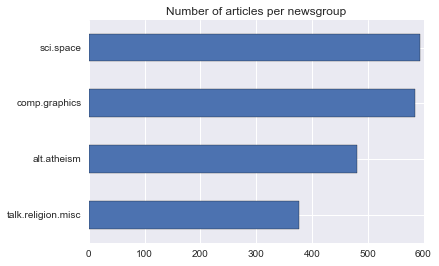

In [123]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

y = newsgroups.target
groups = pd.Series(newsgroups.target_names)
f = groups[y].value_counts(ascending=True).plot(kind='barh', title="Number of articles per newsgroup")

In [161]:
pd.Series(newsgroups.target).value_counts() / len(pd.Series(newsgroups.target))

2    0.291544
1    0.287119
0    0.235988
3    0.185349
dtype: float64

Since we're processing text, we need vectorizers that transform our text features into a usable feature matrix we can feed into our models. You could use `CountVectorizer` or `TfidfVectorizer`, which we both explained in more detail in [20_newsgroups.ipynb](../11_bayes/20_newsgroups.ipynb). 

Feel free to **try out different options**, such as `ngram_range=(0,3)`.

In [141]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()  # or TfidfVectorizer, or different options
X = cv.fit_transform(newsgroups.data)

# X.todense()[:50]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

Fit the model and measure cross-validated accuracy, or AUC. Feel free to **try out different options here** as well, such as the regularization parameter, kernels, etc.

### K-Fold CV

http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html

In [143]:
from sklearn.cross_validation import train_test_split, cross_val_score, KFold

num_instances = len(newsgroups.data)
num_folds = 5

print "Applying KFold cross-validation with %i folds across %i samples" % (num_folds, num_instances)
print

folds = KFold(num_instances, n_folds=num_folds)

i = 0
scores = []

for train_idxs, test_idxs in folds:
    print "Fold: ", i
    print "\tTraining indexes:", train_idxs.min(), "-", train_idxs.max()
    print "\tTest indexes:", test_idxs.min(), "-", test_idxs.max()
    i += 1
    
    X_train, X_test = X[train_idxs], X[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]
    
    model = KNeighborsClassifier(n_neighbors=50)
    model.fit(X_train, y_train)
    
    score = model.score(X_test, y_test)
    scores.append(score)
    
    print "\tKNN Model (50 neighbors) Score: ", score
    print

print
print "MEAN SCORE:", sum(scores) / len(scores)

Applying KFold cross-validation with 5 folds across 2034 samples

Fold:  0
	Training indexes: 407 - 2033
	Test indexes: 0 - 406
	KNN Model (50 neighbors) Score:  0.584766584767

Fold:  1
	Training indexes: 0 - 2033
	Test indexes: 407 - 813
	KNN Model (50 neighbors) Score:  0.552825552826

Fold:  2
	Training indexes: 0 - 2033
	Test indexes: 814 - 1220
	KNN Model (50 neighbors) Score:  0.560196560197

Fold:  3
	Training indexes: 0 - 2033
	Test indexes: 1221 - 1627
	KNN Model (50 neighbors) Score:  0.601965601966

Fold:  4
	Training indexes: 0 - 1627
	Test indexes: 1628 - 2033
	KNN Model (50 neighbors) Score:  0.581280788177


MEAN SCORE: 0.576207017586


**The above code is equivalent to:**

In [149]:
model = KNeighborsClassifier(n_neighbors=50, weights='distance')
scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
print type(scores)

print "Mean Score", scores.mean()

<type 'numpy.ndarray'>
Mean Score 0.588536206403


Obviously you can do better than that.

### Grid Search over many values of k, using both 'uniform' and 'distance' weighting

In [152]:
from sklearn.grid_search import GridSearchCV

# We'll try finding the best value of k, and weights by trying all possible pairs
parameter_grid = [
  {'n_neighbors': range(3, 70, 5), 'weights': ['uniform', 'distance']}
 ]

clf = GridSearchCV(KNeighborsClassifier(), parameter_grid, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [3, 8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [153]:
print
print "GRID SEARCH RESULTS:"
print "\tBest Parameters", clf.best_params_
print "\tBest Score", clf.best_score_

# A list of all scores are stored in clf.grid_scores_
pd.DataFrame(clf.grid_scores_).drop('cv_validation_scores', axis=1).head()


GRID SEARCH RESULTS:
	Best Parameters {'n_neighbors': 3, 'weights': 'distance'}
	Best Score 0.70515970516


,parameters,mean_validation_score
0,"{u'n_neighbors': 3, u'weights': u'uniform'}",0.678747
1,"{u'n_neighbors': 3, u'weights': u'distance'}",0.705160
2,"{u'n_neighbors': 8, u'weights': u'uniform'}",0.641278
3,"{u'n_neighbors': 8, u'weights': u'distance'}",0.664619
4,"{u'n_neighbors': 13, u'weights': u'uniform'}",0.619779


In [154]:
# Cleanup the dataframe so we can plot
scores_df = pd.DataFrame(columns=["n_neighbors", "weights", "score"])

for grid_score in clf.grid_scores_:
    scores_df = scores_df.append({
            "n_neighbors": grid_score.parameters["n_neighbors"], 
            "weights": grid_score.parameters["weights"], 
            "score": grid_score.mean_validation_score
        }, ignore_index=True)


scores_df["n_neighbors"] = scores_df["n_neighbors"].astype(np.int)
scores_df.head()

,n_neighbors,weights,score
0,3,uniform,0.678747
1,3,distance,0.705160
2,8,uniform,0.641278
3,8,distance,0.664619
4,13,uniform,0.619779


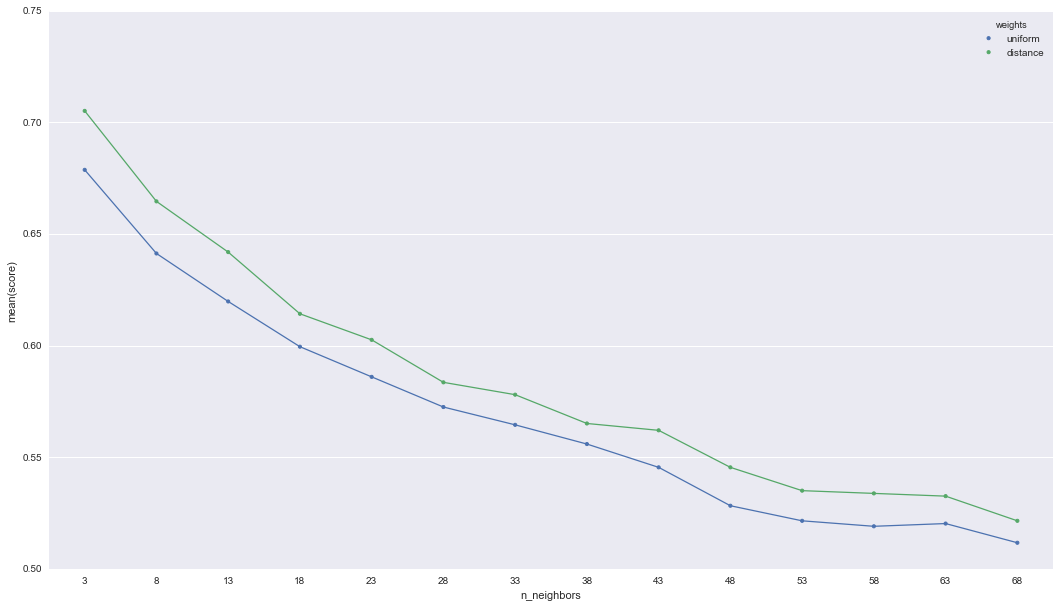

In [155]:
plt.figure(figsize=(18, 10))
sns.pointplot(data=scores_df, x="n_neighbors", y="score", hue="weights", scale=0.4);

## Exercise

1. Given the above distribution of newsgroups (the `y`s), what is reasonable accuracy to expect? What would a naive classier's (guess the most common class) accuracy be?
1. Try out different models, testing their cross-validated accuracy. 
1. Repeat the previous step F1-score and AUC score in addition to accuracy
1. Try out different options (such as regularization parameters, kernels, etc.)
1. Try out different text vectorizers and options
1. If you find a model you like, try different categories (or all of them) and see if this impacts your performance
1. Try to interpret its learned parameters and plot some nice insights

In [187]:
tfidf = CountVectorizer()  # or TfidfVectorizer, or different options
X = tfidf.fit_transform(newsgroups.data)

def try_models():
    # 1. Try out different models, testing their cross-validated accuracy. 

    # Random Forest
    model = RandomForestClassifier(n_estimators=50)

    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
    f1_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=5)

    print "Rand Forest Mean accuracy:", accuracy_scores.mean()
    print "Rand Forest Mean f1 score:", f1_scores.mean()

    # DecisionTrees
    model = DecisionTreeClassifier()

    dt_accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
    dt_f1_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=5)


    print "Dec. Trees Mean Accuracy Score", dt_accuracy_scores.mean()
    print "Dec. Trees Mean F! Scores", dt_f1_scores.mean()

    # LogReg
    from sklearn.multiclass import OneVsRestClassifier

    clf = OneVsRestClassifier(LogisticRegression())

    logreg_accuracy_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    logreg_f1_scores = cross_val_score(clf, X, y, scoring='f1_weighted', cv=5)

    print "LogReg Accuracy", logreg_accuracy_scores.mean()
    print "LogReg F1", logreg_f1_scores.mean()
    
    
print "\nCount Vectorized Input:"
cv = CountVectorizer()  # or TfidfVectorizer, or different options
X = cv.fit_transform(newsgroups.data)

try_models()

print "\nTfIdf Vectorized Input:"
tfidf = TfidfVectorizer()  # or TfidfVectorizer, or different options
X = tfidf.fit_transform(newsgroups.data)

try_models()


Count Vectorized Input:
Rand Forest Mean accuracy: 0.877076411782
Rand Forest Mean f1 score: 0.874606803129
Dec. Trees Mean Accuracy Score 0.814118552225
Dec. Trees Mean F! Scores 0.81129695979
LogReg Accuracy 0.948381980015
LogReg F1 0.948282775126
\TfIdf Vectorized Input:
Rand Forest Mean accuracy: 0.869200570925
Rand Forest Mean f1 score: 0.857980441551
Dec. Trees Mean Accuracy Score 0.777276621475
Dec. Trees Mean F! Scores 0.772204344604
LogReg Accuracy 0.923798427433
LogReg F1 0.923072637882


## Bonus
1. Evaluate all 4 models in a single step using GridSearch

For interpretation, recall that
- LogisticRegression gives you coefficients for the log odds of the corresponding feature
- Random Forests and Decision Trees give you feature importances

In [7]:
# Your code here